# Clustering de nos vols avec K-Means — modèle non supervisé

## Contexte

Ce notebook fait suite à l'analyse de prédiction de prix (`exam_analysis.ipynb`). L'objectif ici est différent : on ne cherche pas à prédire le prix, mais à regrouper les vols qui se ressemblent sans utiliser de variable cible (apprentissage non supervisé).

On utilise l'algorithme K-Means sur `duration` et `price` pour faire ressortir des profils types de vols — par exemple : vols courts et peu chers, vols d'affaires, longs courriers.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [ ]:
df = pd.read_csv("Clean_Dataset.csv")
df.head()


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class_ticket,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Sélection des variables temporelles et tarifaires
Pour identifier des profils de vols cohérents, nous allons isoler deux variables clés et numériques :
- `duration` : La durée de vol en heures.
- `price` : Le tarif du billet.

Ces deux critères permettront à l'algorithme K-Means de regrouper les vols par "logique tarif/temps de trajet".

In [ ]:
X = df[['duration', 'price']].copy()
X.head()

,duration,price
0,2.17,5953
1,2.33,5953
2,2.17,5956
3,2.25,5955
4,2.33,5955


### Standardisation
L'algorithme K-Means utilise des calculs de distance pour créer ses groupes. Comme le prix (allant de 0 à plus de 100 000) et la durée (allant de 1 à 50 heures) ont des échelles très différentes, il est *obligatoire* de tout ramener sur la même échelle. Pour cela, on utilise le `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #standardisation d'une fonction scaler

X_scaled = scaler.fit_transform(X) #Application du scaler a nos cariables x

print(X_scaled[:5])


[[-1.39753079 -0.65806849]
 [-1.3752838  -0.65806849]
 [-1.39753079 -0.65793631]
 [-1.38640729 -0.65798037]
 [-1.3752838  -0.65798037]]


## Modélisation avec K-Means
Le modèle va maintenant chercher à regrouper nos données en 3 clusters distincts. Nous paramétrons `n_clusters=3`. Il attribuera ensuite un numéro de groupe (0, 1 ou 2) à chaque vol.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")

labels = kmeans.fit_predict(X_scaled)

df["Cluster"] = labels
X["Cluster"] = labels

print(df["Cluster"].value_counts())


Cluster
0    155334
1     80950
2     63869
Name: count, dtype: int64


## Affichage des groupes
On va faire un "Scatter plot" de nos vols selon leur prix et leur durée, en colorant selon le groupe trouvé par l'algo.

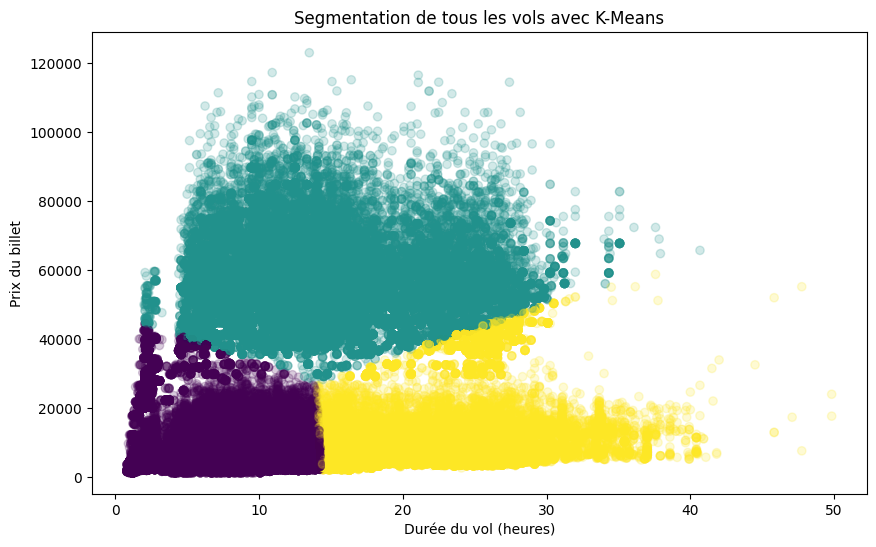

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


plt.scatter(
    x=X["duration"], 
    y=X["price"],
    c=X["Cluster"],
    cmap="viridis",
    alpha=0.2  # Transparence pour mieux voir la densité de 300 000 points
)

plt.xlabel("Durée du vol (heures)")
plt.ylabel("Prix du billet")
plt.title("Segmentation de tous les vols avec K-Means")
plt.show()


## Conclusion — Analyse business et impact

Le K-Means identifie 3 groupes distincts :

- **Groupe "vols courts / pas chers"** : vols de courte durée avec des tarifs bas, typiques des vols Economy sans escale.
- **Groupe "vols affaires"** : vols de durée moyenne mais avec des prix élevés, liés à la classe Business ou aux achats de dernière minute.
- **Groupe "longs courriers"** : durée de vol plus longue et prix les plus élevés.

**Impact métier :** cette segmentation est utile pour une compagnie aérienne. En connaissant les profils types de ses vols, elle peut mieux cibler ses clients et adapter sa grille tarifaire par segment.

**Limites :** l'analyse se limite à deux variables (`duration`, `price`). Intégrer d'autres variables (escales, compagnie, créneau) permettrait d'obtenir des clusters plus fins et plus exploitables.